# Messages Monitoring Model

## Phase 1: Preprocessing the Data

### Load in the Required Libraries

In [78]:
# for dealing with data
import pandas as pd
import numpy as np
from datasets import load_dataset
import re

# for data visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# for processing data
from imblearn.over_sampling import SMOTEN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# for model building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TextVectorization, Embedding, Flatten, Dense, Dropout, LSTM, GRU, Conv1D, Input, GlobalAvgPool1D, GlobalMaxPool1D, Bidirectional, Reshape

# for evaluation metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

### Load in the Datasets

In [3]:
# download the kaggle datasets
# uncomment the following lines to download the datasets
# !kaggle datasets download -d uciml/sms-spam-collection-dataset
# !kaggle datasets download -d team-ai/spam-text-message-classification
# !wget https://raw.githubusercontent.com/DeshDSingh/SMS-SPAM-Detection/master/sms_spam.csv
# !unzip sms-spam-collection-dataset.zip
# !unzip spam-text-message-classification.zip
# !rm sms-spam-collection-dataset.zip
# !rm spam-text-message-classification.zip
# !mv sms_spam.csv ./../data

In [4]:
# read in the datasets
sms_data1 = pd.read_csv("../data/SPAM text message 20170820 - Data.csv")
sms_data2 = pd.read_csv("../data/spam.csv", encoding='latin-1')
sms_data3 = pd.DataFrame((load_dataset("sms_spam")['train']))
sms_data4 = pd.read_csv("./../data/sms_spam.csv")

Reusing dataset sms_spam (/Users/necro_kudo/.cache/huggingface/datasets/sms_spam/plain_text/1.0.0/53f051d3b5f62d99d61792c91acefe4f1577ad3e4c216fb0ad39e30b9f20019c)
100%|██████████| 1/1 [00:00<00:00, 44.12it/s]


In [5]:
# unify the features names
sms_data1.rename({"Category": "label", "Message": "message"}, axis=1, inplace=True)
sms_data1 = sms_data1[["message", "label"]]

# unify the features names & drop unwanted features
sms_data2.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True)
sms_data2.rename({"v1" : "label", "v2" : "message"}, axis=1, inplace=True)
sms_data2 = sms_data2[["message", "label"]]

# unify the features names
sms_data3.rename({"sms" : "message"}, axis=1, inplace=True)
sms_data3['label'] = sms_data3['label'].apply(lambda x: "spam" if x == 1 else "ham")

# unify the features names
sms_data4.rename({"type" : "label", "text" : "message"}, axis=1, inplace=True)
sms_data4 = sms_data4[["message", "label"]]

In [6]:
# concatenate the results to form a bigger dataframe of all the previous ones
sms_big = pd.concat([sms_data1, sms_data2, sms_data3, sms_data4], axis=0)
sms_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22277 entries, 0 to 5558
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  22277 non-null  object
 1   label    22277 non-null  object
dtypes: object(2)
memory usage: 522.1+ KB


Great! Since we concatenated the dataframes together, we need to check for duplicates if present, and drop them.

### Exploratory Data Analysis

In [7]:
# check for duplicates
print(f"Number of observations before dropping duplicates: {len(sms_big)}")
print(f"Number of duplicated observations: {sms_big.duplicated().sum()}")
sms_big.drop_duplicates(inplace=True)
print(f"Number of observations after dropping the duplicates: {len(sms_big)}")


Number of observations before dropping duplicates: 22277
Number of duplicated observations: 10579
Number of observations after dropping the duplicates: 11698


Even though the number of duplicates is alarming (almost 1/2 of the concatenated data), luckily, dropping them will leave us with still a large dataset of over 10K observations

In [8]:
# examine the number of observations for each class
sms_big.label.value_counts()

ham     10124
spam     1574
Name: label, dtype: int64

Before proceeding to examine the imbalance in our data, we will first clean it from unwanted characters

In [9]:
sms_big.message.iloc[0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [10]:
# clean the data by making it all lower-case and getting rid of special characters
for i in range(0,sms_big.shape[0]):
    message = re.sub(pattern='[^a-zA-Z]', repl=' ', string=sms_big.message.iloc[i]) 
    message = message.lower()
    sms_big.message.iloc[i] = message

We will start our data examination through:

- Getting to know the length of our messages
- Descriptive statistices

In [11]:
# adding length column for ease of processing
message_lengths = []
for row in range(0, len(sms_big)):
    message_lengths.append(len(sms_big.message.iloc[row]))
sms_big['length'] = message_lengths

In [12]:
# descriptive statistcs of our data
sms_big.describe()

,length
count,11698.000000
mean,82.356471
std,59.660992
min,2.000000
25%,37.000000
50%,65.000000
75%,124.000000
max,911.000000


In [13]:
# for ham label
print("Descriptive statistics for 'ham':\n")
sms_big[sms_big.label == 'ham'].describe()

Descriptive statistics for 'ham':



,length
count,10124.000000
mean,73.528842
std,58.334125
min,2.000000
25%,35.000000
50%,55.000000
75%,96.000000
max,911.000000


In [14]:
sms_big[sms_big.label == 'ham'].length.sort_values().values[-10:]

array([589, 611, 612, 629, 630, 632, 790, 791, 910, 911])

We will need to drop the these messages with over 700 in length, as they are considered outliers in our case. Dropping them will be ok since there are far more other observations left.

In [15]:
# dropping the outliers in ham label

## getting the index of each outlier
indices = sms_big[sms_big.length > 700].index.values

sms_big.drop(indices, axis=0, inplace=True)

In [16]:
# for spam label
print("Descriptive statistics for 'spam':\n")
sms_big[sms_big.label == 'spam'].describe()

Descriptive statistics for 'spam':



,length
count,1574.000000
mean,139.135959
std,29.012974
min,7.000000
25%,133.000000
50%,149.000000
75%,157.000000
max,224.000000


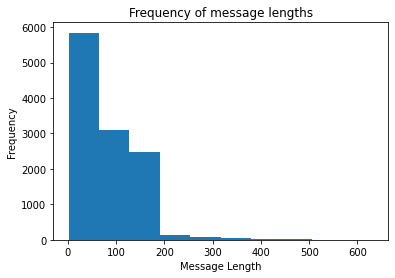

In [17]:
## plot the count plot to show how frequent long and short messages are in the data
sms_big.length.plot.hist()

plt.title("Frequency of message lengths")
plt.xlabel("Message Length")
plt.ylabel("Frequency");

In [18]:
# length of the messages on average
message_lengths = sms_big['length']
avg_message_len = np.mean(message_lengths)
avg_message_len 

82.09372327689414

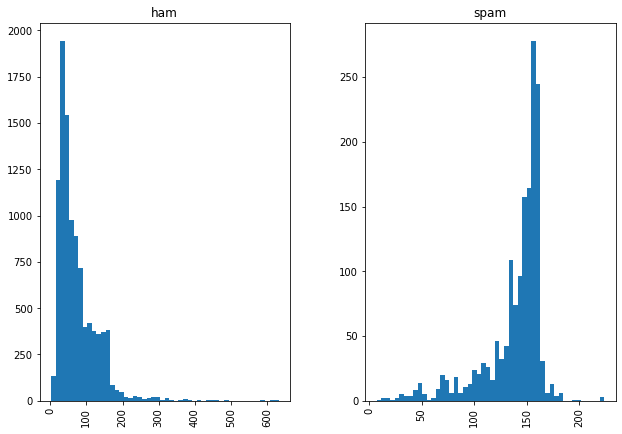

In [19]:
# plot per label
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7), sharex=True, sharey=True)
sms_big.hist(column='length', by='label', bins=50,figsize=(10,7));

# plt.xlabel("Message Length")
# plt.ylabel("Frequency")
# plt.show();

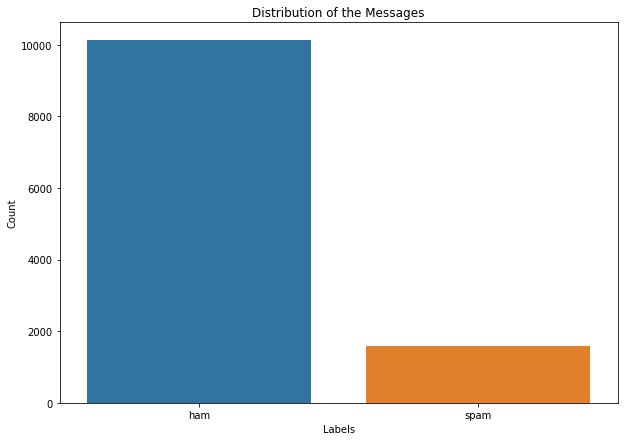

In [20]:
# plot the distribution of the examples in each class
plt.figure(figsize=(10,7))
sns.countplot(x='label', data=sms_big)

plt.title('Distribution of the Messages')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

We can see that our target class, `spam`, is imbalanced. Thus we would use `smote` to fix this issue.

In [21]:
## prepare smote instance along with data splits for oversampling
# sm = SMOTEN(random_state=42)
## prepare under sampler instance for undersampling
unders = RandomUnderSampler(random_state=42,replacement=True)

X = sms_big.message
y = sms_big.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<AxesSubplot:xlabel='label', ylabel='count'>

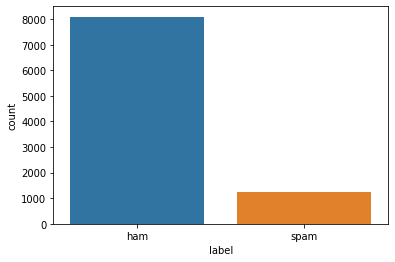

In [22]:
# training data before oversampling/undersampling
train_df = pd.concat([X_train, y_train], axis=1)
sns.countplot(x='label', data=train_df)

<AxesSubplot:xlabel='1', ylabel='count'>

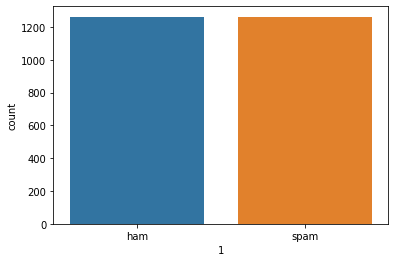

In [23]:
# training data after oversampling/undersampling
X_res, y_res = unders.fit_resample(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1))
X_train_res = pd.Series(X_res.reshape(-1))
y_train_res = pd.Series(y_res.reshape(-1))
train_df = pd.concat([X_train_res, y_train_res], axis=1)
sns.countplot(x=1, data=train_df)

Now lets oversample/undersample the test set too

<AxesSubplot:xlabel='label', ylabel='count'>

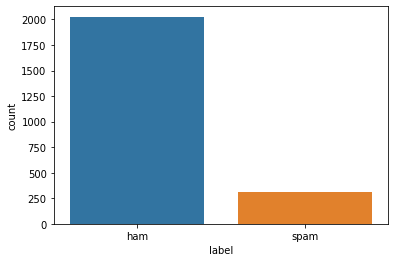

In [24]:
# testing set before oversampling/undersampling
test_df = pd.concat([X_test, y_test], axis=1)
sns.countplot(x='label', data=test_df)

<AxesSubplot:xlabel='1', ylabel='count'>

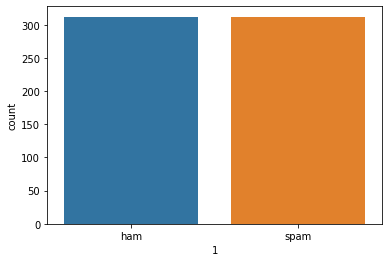

In [25]:
# testing data after oversampling/undersampling
X_res, y_res = unders.fit_resample(np.array(X_test).reshape(-1,1), np.array(y_test).reshape(-1,1))
X_test_res = pd.Series(X_res.reshape(-1))
y_test_res = pd.Series(y_res.reshape(-1))
test_df = pd.concat([X_test_res, y_test_res], axis=1)
sns.countplot(x=1, data=test_df)

In [26]:
# shape of each set
X_train_res.shape, y_train_res.shape, X_test_res.shape, y_test_res.shape

((2524,), (2524,), (624,), (624,))

In [27]:
# convert the datasets to numpy arrays
X_train_res = X_train_res.to_numpy()
y_train_res = y_train_res.to_numpy()

X_test_res = X_test_res.to_numpy()
y_test_res = y_test_res.to_numpy()

In [28]:
# apply label encoder to transform the caategorical target variable
le = LabelEncoder()
y_train_res = le.fit_transform(y_train_res)
y_test_res = le.fit_transform(y_test_res)

In [29]:
y_train_res

array([0, 0, 0, ..., 1, 1, 1])

In [30]:
# sample random observations to become one with the data
from random import randint
index = randint(0, len(sms_big) - 1)
print(f"Message:\n{sms_big.iloc[index].message}")
print(f"Label:\n{sms_big.iloc[index].label}")

Message:
yep then is fine      or      for ice age 
Label:
ham


### Text Tokenization

Now, after getting to know our data, and cleaning it, we can proceed to converting our categorical data into numerical ones, so our models can successfully process them

In [31]:
# get max vocabulary in the data (messages)
vocab_set = set()
for message in X_train_res:
    message = message.split(sep=' ')
    for word in message:
        vocab_set.add(word.lower().strip())

# get average words (tokens) in each message
avg_token_length = round(sum([len(i.split()) for i in X_train_res])/len(X_train_res))

print(f"Number of vocabulary words: {len(vocab_set)}")
print(f"Average length of messages: {avg_token_length}")

Number of vocabulary words: 4330
Average length of messages: 19


We will go with a `10000`, as our data seemed to have a close size to it.

In [32]:
max_tokens = 10000
output_sequence_length = avg_token_length

# create a text vectorization layer
text_vectorizer = TextVectorization(max_tokens=max_tokens, 
                                    standardize="lower_and_strip_punctuation", 
                                    split="whitespace", 
                                    ngrams=None, 
                                    output_mode="int",
                                    output_sequence_length=output_sequence_length)

# apply it to our training set
text_vectorizer.adapt(X_train_res)

2022-08-22 18:13:09.053553: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Examine our text vectorizer findings 

In [33]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] 
bottom_5_words = words_in_vocab[-5:] 
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 4331
Top 5 most common words: ['', '[UNK]', 'to', 'you', 'a']
Bottom 5 least common words: ['absolutly', 'absolutely', 'above', 'abj', 'abdomen']


In [34]:
# initialize messages embeddings
embedding = Embedding(input_dim=len(text_vectorizer.get_vocabulary()), 
                             output_dim=128, 
                             embeddings_initializer="uniform", 
                             input_length=output_sequence_length) 

Now, we are ready to proceed to the next phase, Model development!

## Phase 2: Model Development

We will experiment with various model architecture, and compare them to get the optimal one for this case.

Before we proceed, we will define a function that we can use to evaluate our model's performance

In [35]:
# define a function to evaluate a model's performance

def evaluate_custom_model(y_true, y_pred):
    """
    A function used to evaluate model's performance
    
    - Args:
     y_true: the true labels of the data used
     y_pred: the predictions made by the model
    
    - Returns:
     A dictionary of accuracy and f1-score
    """
    accuracy = accuracy_score(y_true, y_pred) * 100
    _, _, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    
    results = {
        'accuracy': accuracy,
        'f1-score': f1
    }
    
    return results

### Model 0: Baseline model using sklearn's MultiNomialNB

In [36]:
# create the model
model_0 = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

# fit the model
model_0.fit(X_train_res, y_train_res)

Pipeline(steps=[('tfid', TfidfVectorizer()), ('mnb', MultinomialNB())])

In [37]:
# evaluate our model

y_pred = model_0.predict(X_test_res)
evaluate_custom_model(y_true=y_test_res, y_pred=y_pred)

{'accuracy': 95.99358974358975, 'f1-score': 0.9599333249433031}

Even though the evaluation metrics are high, it is not a good indicator of its success

In [38]:
def custom_data_test(model):
    """
    Tests the model on real spam custom data
    Args:
        model (ML model): a model to test the spam custom data on
    """
    data = [
        'DPD-7895 Delivery Attempt made, recipient was not reached. Reschedule Delivery: http://www.apd-parcel.cf',
        'Amazon : Your account is currently locked for security reasons. Please verify your payment quickly or we will delete your account',
        'CENSUS: There is missing information from your Census application. Update your application by sending your account information to 9663434345',
        'We solve homeworks for everyone. If you want to score good in you exams contact us. very effective'
    ]
    
    y_true = [1,1,1,1]
    
    y_pred = model.predict(data)
    if y_pred[0] != 0 or y_pred[0] != 1:
        y_pred = np.squeeze(np.round(y_pred))

    result = y_pred == y_true
    output = 0
    for i in result:
        if i == True:
            output += 1
    
    return f"Model Performance on custom spam dataset: {output / len(result) * 100}%"

In [39]:
custom_data_test(model_0)

'Model Performance on custom spam dataset: 75.0%'

### Model 1: Simple Deep Model

In [40]:
# build the model
inputs = Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = GlobalAvgPool1D()(x)
outputs = Dense(units=1, activation='sigmoid')(x)

model_1 = Model(inputs, outputs, name='simple_model_1')

# compile the model
model_1.compile(
    loss='binary_crossentropy',
    optimizer= Adam(),
    metrics=['accuracy']
)

# fit the model
history_1 = model_1.fit(
    X_train_res,
    y_train_res,
    epochs=5
)

Epoch 1/5
79/79 [==============================] - 2s 8ms/step - loss: 0.5631 - accuracy: 0.8788
Epoch 2/5
79/79 [==============================] - 1s 9ms/step - loss: 0.3143 - accuracy: 0.9330
Epoch 3/5
79/79 [==============================] - 1s 9ms/step - loss: 0.1972 - accuracy: 0.9505
Epoch 4/5
79/79 [==============================] - 1s 9ms/step - loss: 0.1388 - accuracy: 0.9643
Epoch 5/5
79/79 [==============================] - 1s 8ms/step - loss: 0.1042 - accuracy: 0.9739


These high accuracy scores might suggest an overfitting, especially when our data was imbalanced and we had to undersample

In [41]:
# evaluate the model
pred_probs = model_1.predict(X_test_res)
preds = np.squeeze(np.round(pred_probs))
evaluate_custom_model(y_test_res, preds)

{'accuracy': 95.99358974358975, 'f1-score': 0.9598987185584105}

In [42]:
custom_data_test(model_1)

'Model Performance on custom spam dataset: 50.0%'

We will continue to experiment with our model development to better predict them.

### Model 2: Deep Model with LSTM

Before we build the next models, we need to create a new embedding layer for each new model, as the embedding layer is a learned representaion, which when used through several models, it might cause data leakage

In [43]:
# create model_2 embedding layer
embedding = Embedding(input_dim=len(text_vectorizer.get_vocabulary()), 
                             output_dim=128, 
                             embeddings_initializer="uniform", 
                             input_length=output_sequence_length) 

In [44]:
# build the model
inputs = Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = LSTM(128)(x)
outputs = Dense(units=1, activation='sigmoid')(x)

model_2 = Model(inputs, outputs, name='lstm_model_2')

# compile the model
model_2.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

# fit the model
history_2 = model_2.fit(
    X_train_res,
    y_train_res,
    epochs=5
)

Epoch 1/5
79/79 [==============================] - 6s 48ms/step - loss: 0.2472 - accuracy: 0.9053
Epoch 2/5
79/79 [==============================] - 4s 51ms/step - loss: 0.0512 - accuracy: 0.9869
Epoch 3/5
79/79 [==============================] - 4s 52ms/step - loss: 0.0154 - accuracy: 0.9952
Epoch 4/5
79/79 [==============================] - 4s 56ms/step - loss: 0.0057 - accuracy: 0.9980
Epoch 5/5
79/79 [==============================] - 4s 55ms/step - loss: 0.0107 - accuracy: 0.9972


In [45]:
# evaluate the model
pred_probs = model_2.predict(X_test_res)
preds = np.squeeze(np.round(pred_probs))
evaluate_custom_model(y_test_res, preds)

{'accuracy': 97.75641025641025, 'f1-score': 0.977562028047465}

In [46]:
custom_data_test(model_2)

'Model Performance on custom spam dataset: 75.0%'

### Model 3: Deep Model with GRU

In [47]:
# create model_3 embedding layer
embedding = Embedding(input_dim=len(text_vectorizer.get_vocabulary()), 
                             output_dim=128, 
                             embeddings_initializer="uniform", 
                             input_length=output_sequence_length) 

In [48]:
# build the model
inputs = Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = GRU(128)(x)
outputs = Dense(units=1, activation='sigmoid')(x)

model_3 = Model(inputs, outputs, name='gru_model_3')

# compile the model
model_3.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

# fit the model
history_3 = model_3.fit(
    X_train_res,
    y_train_res,
    epochs=5
)

Epoch 1/5
79/79 [==============================] - 6s 42ms/step - loss: 0.3000 - accuracy: 0.8566
Epoch 2/5
79/79 [==============================] - 4s 54ms/step - loss: 0.0499 - accuracy: 0.9838
Epoch 3/5
79/79 [==============================] - 4s 49ms/step - loss: 0.0103 - accuracy: 0.9964
Epoch 4/5
79/79 [==============================] - 4s 53ms/step - loss: 0.0024 - accuracy: 0.9996
Epoch 5/5
79/79 [==============================] - 4s 52ms/step - loss: 3.0448e-04 - accuracy: 1.0000


In [49]:
# evaluate the model
pred_probs = model_3.predict(X_test_res)
preds = np.squeeze(np.round(pred_probs))
evaluate_custom_model(y_test_res, preds)

{'accuracy': 98.5576923076923, 'f1-score': 0.9855765896955827}

In [50]:
custom_data_test(model_3)

'Model Performance on custom spam dataset: 75.0%'

### Model 4: Deep Model with BRNN

In [51]:
# create model_4 embedding layer
embedding = Embedding(input_dim=len(text_vectorizer.get_vocabulary()), 
                             output_dim=128, 
                             embeddings_initializer="uniform", 
                             input_length=output_sequence_length) 

In [52]:
# build the model
inputs = Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = Bidirectional(LSTM(128))(x)
outputs = Dense(units=1, activation='sigmoid')(x)

model_4 = Model(inputs, outputs, name='brnn_model_4')

# compile the model
model_4.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

# fit the model
history_4 = model_4.fit(
    X_train_res,
    y_train_res,
    epochs=5
)

Epoch 1/5
79/79 [==============================] - 14s 90ms/step - loss: 0.2321 - accuracy: 0.9128
Epoch 2/5
79/79 [==============================] - 6s 82ms/step - loss: 0.0302 - accuracy: 0.9921
Epoch 3/5
79/79 [==============================] - 7s 83ms/step - loss: 0.0168 - accuracy: 0.9945
Epoch 4/5
79/79 [==============================] - 6s 82ms/step - loss: 0.0028 - accuracy: 0.9992
Epoch 5/5
79/79 [==============================] - 6s 78ms/step - loss: 7.7229e-04 - accuracy: 1.0000


In [53]:
# evaluate the model
pred_probs = model_4.predict(X_test_res)
preds = np.squeeze(np.round(pred_probs))
evaluate_custom_model(y_test_res, preds)

{'accuracy': 97.27564102564102, 'f1-score': 0.9727479415807119}

In [54]:
custom_data_test(model_4)

'Model Performance on custom spam dataset: 75.0%'

### Model 5: Deep Model with Conv1D

In [55]:
# create model_5 embedding layer
embedding = Embedding(input_dim=len(text_vectorizer.get_vocabulary()), 
                             output_dim=128, 
                             embeddings_initializer="uniform", 
                             input_length=output_sequence_length) 

In [56]:
# build the model
inputs = Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = Conv1D(filters=32, kernel_size=5, activation='relu')(x)
x = GlobalMaxPool1D()(x)
x = Dense(units=32, activation='relu')(x)
outputs = Dense(units=1, activation='sigmoid')(x)

model_5 = Model(inputs, outputs, name='conv1d_model_5')

# compile the model
model_5.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

# fit the model
history_5 = model_5.fit(
    X_train_res,
    y_train_res,
    epochs=5
)

Epoch 1/5
79/79 [==============================] - 2s 12ms/step - loss: 0.4288 - accuracy: 0.8463
Epoch 2/5
79/79 [==============================] - 1s 11ms/step - loss: 0.0715 - accuracy: 0.9802
Epoch 3/5
79/79 [==============================] - 1s 12ms/step - loss: 0.0120 - accuracy: 0.9972
Epoch 4/5
79/79 [==============================] - 1s 12ms/step - loss: 0.0049 - accuracy: 0.9992
Epoch 5/5
79/79 [==============================] - 1s 12ms/step - loss: 0.0019 - accuracy: 0.9996


In [57]:
# evaluate the model
pred_probs = model_5.predict(X_test_res)
preds = np.squeeze(np.round(pred_probs))
evaluate_custom_model(y_test_res, preds)

{'accuracy': 98.3974358974359, 'f1-score': 0.9839737004314774}

In [58]:
custom_data_test(model_5)

'Model Performance on custom spam dataset: 50.0%'

### Model 6: Deep Model with Modifications

In [128]:
# create model_6 embedding layer
embedding = Embedding(input_dim=len(text_vectorizer.get_vocabulary()), 
                             output_dim=128, 
                             embeddings_initializer="uniform", 
                             input_length=output_sequence_length) 

In [129]:
# build the model
inputs = Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = Bidirectional(LSTM(256))(x)
x = Reshape((512,1))(x)
x = Conv1D(filters=32, kernel_size=5, activation='relu')(x)
x = GlobalMaxPool1D()(x)
x = Dense(units=32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(units=16, activation='relu')(x)
outputs = Dense(units=1, activation='sigmoid')(x)

model_6 = Model(inputs, outputs, name='mods_model_6')

# compile the model
model_6.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

# fit the model
history_6 = model_6.fit(
    X_train_res,
    y_train_res,
    epochs=5
)

Epoch 1/5
79/79 [==============================] - 27s 239ms/step - loss: 0.5051 - accuracy: 0.8098
Epoch 2/5
79/79 [==============================] - 19s 240ms/step - loss: 0.3005 - accuracy: 0.9445
Epoch 3/5
79/79 [==============================] - 18s 229ms/step - loss: 0.1291 - accuracy: 0.9735
Epoch 4/5
79/79 [==============================] - 23s 290ms/step - loss: 0.0781 - accuracy: 0.9842
Epoch 5/5
79/79 [==============================] - 27s 344ms/step - loss: 0.0351 - accuracy: 0.9948


In [130]:
# evaluate the model
pred_probs = model_6.predict(X_test_res)
preds = np.squeeze(np.round(pred_probs))
evaluate_custom_model(y_test_res, preds)

{'accuracy': 97.43589743589743, 'f1-score': 0.9743587109499396}

In [131]:
custom_data_test(model_6)

'Model Performance on custom spam dataset: 100.0%'

Great. Our modified model scored 100% on our custom spam data.

In [132]:
test = model_6.predict(['Hey, can I come today?', 
                        'How was your game yesterday?', 
                        'Here is Ahmeds number 96605093434', 
                        'Free tickets to dinseyland. Offer only for you, send your id now!!!'])
np.squeeze(np.round(test))

array([0., 0., 0., 1.], dtype=float32)

Amazing !!. Looks like our model is performing well on custom data again. We will proceed now to deployment.

In [ ]:
# save the model
# model_6.save('spam_detection_model')